## Word Embeddings

In [7]:
from __future__ import absolute_import, print_function, division, unicode_literals
import tensorflow as tf

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [9]:
embedding_layer = layers.Embedding(1000,5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

In [10]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.01148931,  0.02270687,  0.01478517,  0.04652976,  0.0011053 ],
       [ 0.03709913, -0.03763461, -0.02852543, -0.0454707 ,  0.00678336],
       [ 0.03080398, -0.00985748, -0.02907696, -0.02151342,  0.0081485 ]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15).

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape (samples, sequence_length, embedding_dimensionality). To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer.

### Learning embeddings from scratch

In [11]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', split = (tfds.Split.TRAIN, tfds.Split.TEST), 
                                          with_info= True, as_supervised= True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /Users/ujjawalpathak/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [14]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [17]:
# We will use the padded_batch method to standardize the lengths of the reviews.

padded_shapes = ([None], ())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes= padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes= padded_shapes)

In [19]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 768, 3769,   14, ...,    0,    0,    0],
       [1658,   40,   15, ...,    0,    0,    0],
       [2990, 3678,  670, ...,    0,    0,    0],
       ...,
       [ 373,    6, 1137, ..., 4829,  714, 7975],
       [ 796, 6103, 1717, ...,    0,    0,    0],
       [  12, 5331,   13, ...,    0,    0,    0]])

Create a simple model
We will use the Keras Sequential API to define our model. In this case it is a "Continuous bag of words" style model.

Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [20]:
embedding_dim = 16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    validation_data = test_batches, validation_steps= 20)

Epoch 1/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.4963 - accuracy: 0.7628 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2798 - accuracy: 0.8965 - val_loss: 0.3328 - val_accuracy: 0.8400
Epoch 3/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2276 - accuracy: 0.9172 - val_loss: 0.2765 - val_accuracy: 0.8650
Epoch 4/10
2500/2500 [==============================] - 14s 5ms/step - loss: 0.1928 - accuracy: 0.9302 - val_loss: 0.3970 - val_accuracy: 0.8450
Epoch 5/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.1714 - accuracy: 0.9416 - val_loss: 0.2966 - val_accuracy: 0.8900
Epoch 6/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.1538 - accuracy: 0.9482 - val_loss: 0.2237 - val_accuracy: 0.9100
Epoch 7/10
2500/2500 [==============================] - 14s 6ms/step - loss: 0.1406 - accuracy: 0.9535 - val_loss: 0.3452

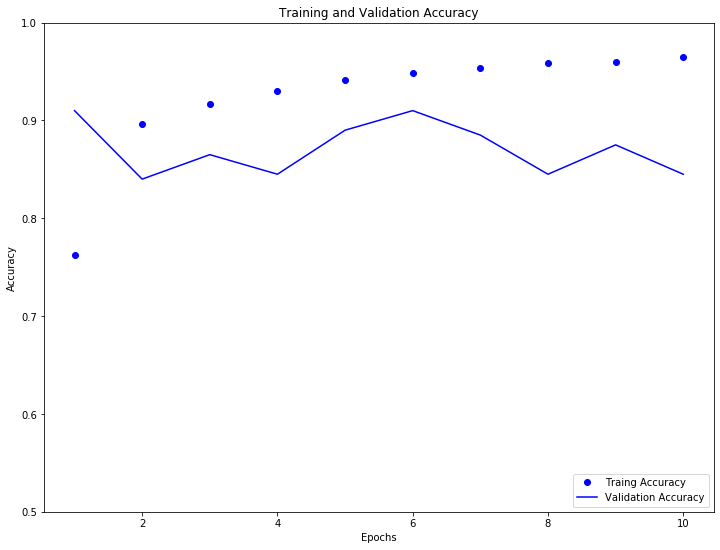

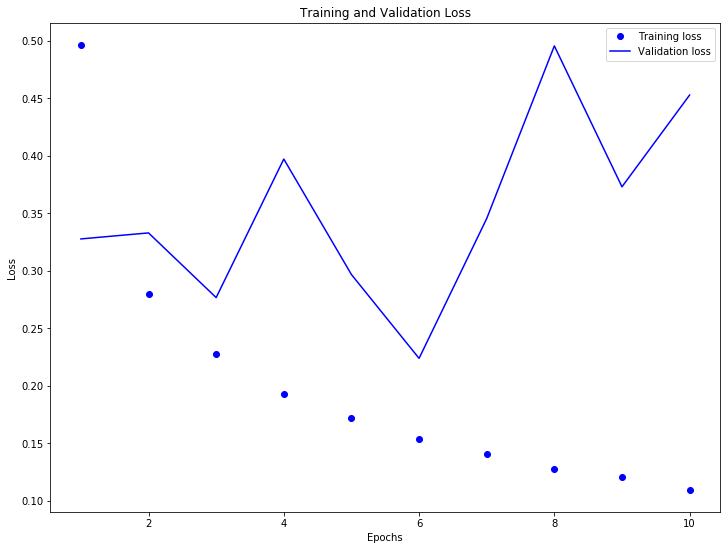

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Traing Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.5,1)
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Retrieve the learned embeddings

In [25]:
e = model.layers[0]
weights = e.get_weights()[0]
weights.shape

(8185, 16)

In [26]:
# writes the weights to disk

import io 

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv','w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [27]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')